In [1]:
!   pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.8 MB/s 


## Importing Libraries

In [2]:
import keras_tuner as kt
from keras_tuner import HyperParameters
from kerastuner.tuners import BayesianOptimization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout,Activation
from keras.layers import Conv2D , MaxPooling2D , GlobalMaxPooling2D

from keras.callbacks import LearningRateScheduler,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from keras.layers import BatchNormalization
from keras.layers import Resizing

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet

In [4]:
import sklearn
from sklearn.metrics import classification_report , confusion_matrix , ConfusionMatrixDisplay

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import time

## Defining Reusable Functions

In [8]:
def plot(history, title = 'Model Accuracy', xlabel = 'Epochs', ylabel= 'Accuracy', plot1='accuracy', plot2="val_accuracy"):

    plt.plot(history.history[f'{plot1}'])
    plt.plot(history.history[f'{plot2}'])
    plt.title(f'{title}')
    plt.xlabel(f'{xlabel}')
    plt.ylabel(f'{ylabel}')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [9]:
# def compileModel(model):
#     model.compile(
#         loss = 'categorical_crossentropy',
#         optimizer = "adam",
#         metrics = ['accuracy']
#      )
    
#     return model

In [10]:
early_stop = EarlyStopping(
        monitor = 'val_loss',
        patience = 10
        )

reduce_lr = ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.01,
        patience = 10
        )
    
def scheduler(epoch, lr = 0.01):
        if epoch < 10 : 
            return lr
        else :
            return lr * tf.math.exp(-0.1)
    
lr = LearningRateScheduler(scheduler)

checkpoint_path = "checkpoints/model_5/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
        )

In [11]:
def plot_cm(actual,prection,classes,title):
    cm = confusion_matrix(actual,prediction)
 
    plt.figure(figsize=(12, 8))
    class_count = len(classes)
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True,  fmt='g', cmap='BuGn',annot_kws={"size": 16},linewidths=1, linecolor="black")       
    plt.xticks(np.arange(class_count)+0.5, classes)
    plt.yticks(np.arange(class_count)+0.5, classes,rotation=0)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

## Dataset

In [12]:
classes = os.listdir(r"Test")
print(classes)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [13]:
data = ImageDataGenerator(rescale = 1/255.0)
target_size = (224,224)
batch_size = 32

train = data.flow_from_directory(
        "Train",
        target_size=target_size,
        batch_size=batch_size,
        classes = classes,
        class_mode = "categorical",
        shuffle=False)

validate = data.flow_from_directory(
        "Validate",
        target_size=target_size,
        batch_size=batch_size,
        classes = classes,
        class_mode = "categorical",
        shuffle=False)

test = data.flow_from_directory(
        "Test",
        target_size=target_size,
        batch_size=batch_size,
        classes = classes,
        class_mode = "categorical",
        shuffle=False)

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


## Model 
MobileNet
*   All layers freezed 
*   Tuned ANN



In [22]:
def buildModel(hp):

    base_model = MobileNet(
    input_shape=(244,244,3),
    include_top=False,
    weights="imagenet",
    )

    base_model.trainable = False
    
    #  TOP MODEL

    layers = hp.Int("Layers :",1,5)
    dropout = hp.Boolean("Dropout : ")
    activationList = ['relu','sigmoid','softmax','tanh','selu','elu']
    optimizerList = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']

    top_model = Sequential()
    
    for i in range(layers):
        top_model.add(Dense(units=hp.Int(f'Dense Layer {i} : ', 32, 1024, step=32),
                    activation=hp.Choice(f'Activation {i} : ',activationList)))
        
        if(dropout == True):
            top_model.add(Dropout(rate=hp.Float('Dropout Rate : ', 0.4 , 0.8 ,step=0.1)))

    top_model.add(Dense(5, activation="softmax"))

    
    model = Sequential([base_model,Flatten(input_shape=(7,7,1024)),top_model])

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = hp.Choice('Optimizer : ',optimizerList),
        metrics = ['accuracy'])

    return model

In [26]:
tuner = BayesianOptimization(hypermodel=buildModel,
                             objective="val_accuracy",
                             max_trials=20,
                             executions_per_trial=1,
                             directory="Tuned",
                             project_name="ann"
                        )

INFO:tensorflow:Reloading Oracle from existing project Tuned/ann/oracle.json


In [27]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
Layers : (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
Dropout :  (Boolean)
{'default': False, 'conditions': []}
Dense Layer 0 :  (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': None}
Activation 0 :  (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'softmax', 'tanh', 'selu', 'elu'], 'ordered': False}
Optimizer :  (Choice)
{'default': 'SGD', 'conditions': [], 'values': ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl'], 'ordered': False}


In [28]:
tuner.search(train, epochs=2, validation_data=validate)

Trial 20 Complete [00h 01m 30s]
val_accuracy: 0.9887999892234802

Best val_accuracy So Far: 0.9911999702453613
Total elapsed time: 01h 04m 47s
INFO:tensorflow:Oracle triggered exit


In [29]:
tuner.results_summary()

Results summary
Results in Tuned/ann
Showing 10 best trials
Trial summary
Hyperparameters:
Layers :: 1
Dropout : : True
Dense Layer 0 : : 576
Activation 0 : : relu
Optimizer : : Ftrl
Dropout Rate : : 0.4
Dense Layer 1 : : 32
Activation 1 : : selu
Dense Layer 2 : : 32
Activation 2 : : relu
Dense Layer 3 : : 32
Activation 3 : : elu
Dense Layer 4 : : 1024
Activation 4 : : relu
Score: 0.9911999702453613
Trial summary
Hyperparameters:
Layers :: 1
Dropout : : True
Dense Layer 0 : : 896
Activation 0 : : relu
Optimizer : : Ftrl
Dropout Rate : : 0.4
Dense Layer 1 : : 32
Activation 1 : : elu
Dense Layer 2 : : 32
Activation 2 : : relu
Dense Layer 3 : : 32
Activation 3 : : relu
Dense Layer 4 : : 1024
Activation 4 : : selu
Score: 0.9911999702453613
Trial summary
Hyperparameters:
Layers :: 1
Dropout : : False
Dense Layer 0 : : 1024
Activation 0 : : relu
Optimizer : : Ftrl
Dropout Rate : : 0.4
Dense Layer 1 : : 32
Activation 1 : : elu
Dense Layer 2 : : 32
Activation 2 : : relu
Dense Layer 3 : : 32
Ac

## Building Best Model

In [30]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [31]:
model = tuner.hypermodel.build(best_hps)

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 sequential_2 (Sequential)   (None, 5)                 28904837  
                                                                 
Total params: 32,133,701
Trainable params: 28,904,837
Non-trainable params: 3,228,864
_________________________________________________________________


In [33]:
epochs = 50
batch_size = 128

start = time.time()
history = model.fit(train , epochs = epochs , batch_size = batch_size , validation_data = validate , callbacks = [early_stop , checkpoint , lr])
end = time.time()

Epoch 1/50
313/313 [==============================] - 46s 141ms/step - loss: 0.8509 - accuracy: 0.7378 - val_loss: 0.2565 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 2/50
313/313 [==============================] - 44s 140ms/step - loss: 0.2077 - accuracy: 0.9616 - val_loss: 0.1071 - val_accuracy: 0.9868 - lr: 0.0010
Epoch 3/50
313/313 [==============================] - 44s 142ms/step - loss: 0.1213 - accuracy: 0.9766 - val_loss: 0.0633 - val_accuracy: 0.9920 - lr: 0.0010
Epoch 4/50
313/313 [==============================] - 43s 138ms/step - loss: 0.0894 - accuracy: 0.9821 - val_loss: 0.0533 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 5/50
313/313 [==============================] - 42s 136ms/step - loss: 0.0714 - accuracy: 0.9863 - val_loss: 0.0381 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 6/50
313/313 [==============================] - 42s 135ms/step - loss: 0.0609 - accuracy: 0.9857 - val_loss: 0.0350 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 7/50
313/313 [==============================] 

In [34]:
print(f"time taken for fitting : {end-start}s")

time taken for fitting : 843.7129817008972s


In [35]:
model.save("SavedModels/model_5")

INFO:tensorflow:Assets written to: SavedModels/model_5/assets


INFO:tensorflow:Assets written to: SavedModels/model_5/assets


In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

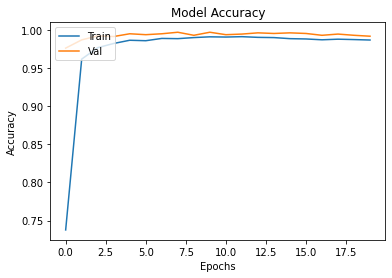

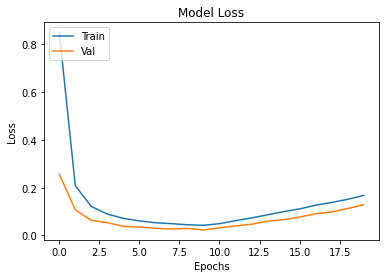

In [37]:
plot( history, 'Model Accuracy', 'Epochs', 'Accuracy','accuracy',"val_accuracy" )
plot( history, 'Model Loss', 'Epochs', 'Loss','loss',"val_loss" )

# Results

In [38]:
model  = tf.keras.models.load_model("SavedModels/model_5")

### Test

In [39]:
probability = model.predict(test)
actual = test.labels

prediction = []

for i, p in enumerate(probability):
            pred_index = np.argmax(p)         
            true_index = test.labels[i]  # labels are integer values
            prediction.append(pred_index)

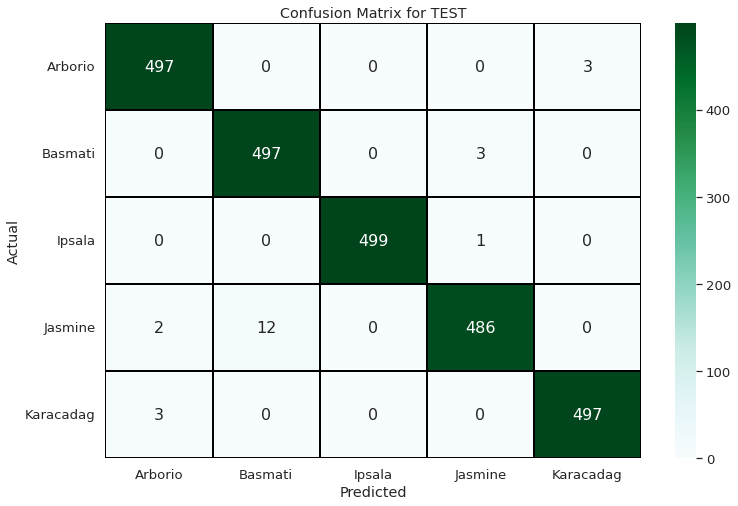

In [40]:
plot_cm(actual,prediction,classes,"TEST")

In [41]:
report = classification_report(actual, prediction)
print("----------------- Classification report for TEST -------------------------- \n\n")
print(report)

----------------- Classification report for TEST -------------------------- 


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       0.98      0.99      0.99       500
           2       1.00      1.00      1.00       500
           3       0.99      0.97      0.98       500
           4       0.99      0.99      0.99       500

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



### Validate

In [42]:
probability = model.predict(validate)
actual = validate.labels

prediction = []

for i, p in enumerate(probability):
            pred_index = np.argmax(p)         
            true_index = validate.labels[i]  # labels are integer values
            prediction.append(pred_index)

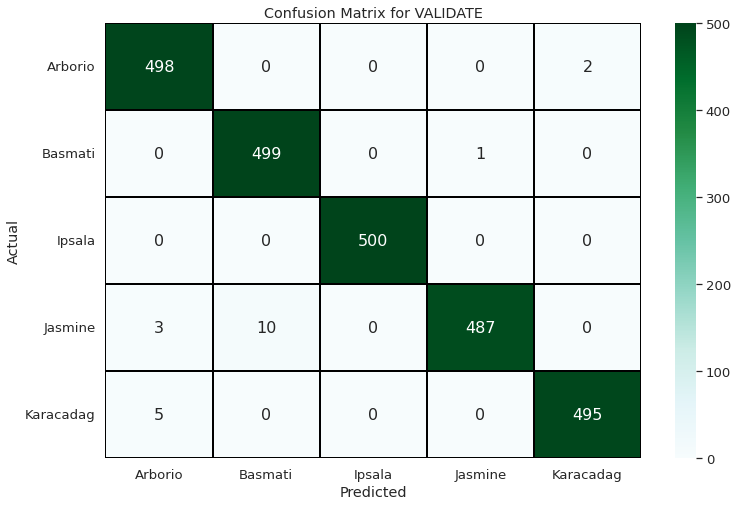

In [43]:
plot_cm(actual,prediction,classes,"VALIDATE")

In [44]:
report = classification_report(actual, prediction)
print("----------------- Classification report for VALIDATE -------------------------- \n\n")
print(report)

----------------- Classification report for VALIDATE -------------------------- 


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       500
           1       0.98      1.00      0.99       500
           2       1.00      1.00      1.00       500
           3       1.00      0.97      0.99       500
           4       1.00      0.99      0.99       500

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



### Train

In [45]:
probability = model.predict(train)
actual = train.labels

prediction = []

for i, p in enumerate(probability):
            pred_index = np.argmax(p)         
            true_index = train.labels[i]  # labels are integer values
            prediction.append(pred_index)

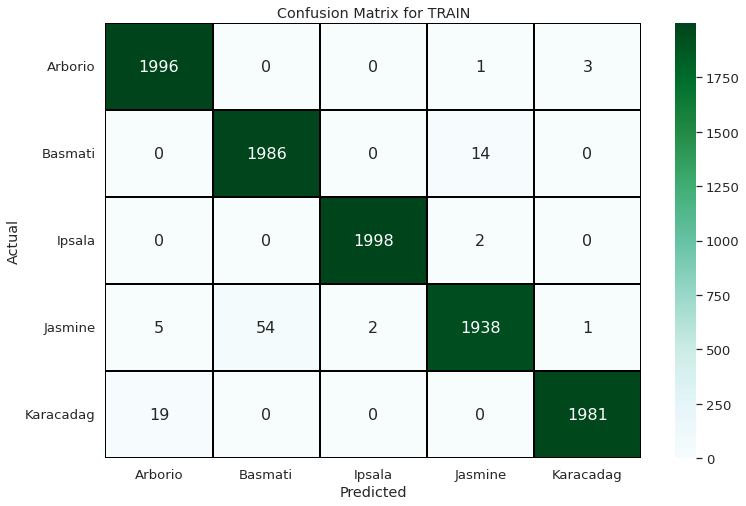

In [46]:
plot_cm(actual,prediction,classes,"TRAIN")

In [47]:
report = classification_report(actual, prediction)
print("----------------- Classification report for TRAIN -------------------------- \n\n")
print(report)

----------------- Classification report for TRAIN -------------------------- 


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2000
           1       0.97      0.99      0.98      2000
           2       1.00      1.00      1.00      2000
           3       0.99      0.97      0.98      2000
           4       1.00      0.99      0.99      2000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

